In [54]:
import pandas as pd
import numpy as np
import pycaret.classification as pc

import matplotlib.pyplot as plt

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

# Configurar MLFLOW

In [2]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Projeto Vinhos'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

2024/04/03 20:30:55 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/04/03 20:30:55 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [10]:
train_test_split?

Signature:
train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Docstring:
Split arrays or matrices into random train and test subsets.

Quick utility that wraps input validation,
``next(ShuffleSplit().split(X, y))``, and application to input data
into a single call for splitting (and optionally subsampling) data into a
one-liner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. If ``train_size`` is also None, it will
    be set to 0.25.

trai

In [14]:
from sklearn.model_selection import train_test_split


data_cols = ['alcohol','volatile acidity', 'free sulfur dioxide','residual sugar', 'target']
train_perc = 0.8


with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):
    
    df_dev = pd.read_parquet('../data/raw/base_dev.parquet')
    df_dev = df_dev[data_cols].copy()
    
    df_dev.to_parquet("../data/processed/data_filtered.parquet")
    
    xtrain, xtest, ytrain, ytest = train_test_split(df_dev[['alcohol','volatile acidity', 'free sulfur dioxide','residual sugar']],
                                                    df_dev['target'],                                                
                                                    train_size=train_perc,
                                                    stratify=df_dev['target'])    
    xtrain['target'] = ytrain
    xtest['target'] = ytest
    xtrain.to_parquet('../data/processed/base_train.parquet')
    xtest.to_parquet('../data/processed/base_test.parquet')

    mlflow.log_params({
        'perc-teste': 1-train_perc,
        'colunas-selecionadas': data_cols
    })
    mlflow.log_metrics({
        'qtd_linhas_treino': xtrain.shape[0],
        'qtd_linhas_teste': xtest.shape[0],
    })




# Treinamento do Modelo 

In [28]:
from sklearn.model_selection import validation_curve


def plot_parameter_validation_curve(X, Y, param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plt.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = X, 
                                                 y = Y, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=10,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Curva Validação Modelo " + model_name)
    plt.xlabel(param_name)
    plt.ylabel("Score ("+scoring+")")
    if logx:
        plt.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plt.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plt.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


In [55]:
mlflow.end_run()

In [65]:
from sklearn.metrics import roc_curve

roc_curve?

Signature:
roc_curve(
    y_true,
    y_score,
    *,
    pos_label=None,
    sample_weight=None,
    drop_intermediate=True,
)
Docstring:
Compute Receiver operating characteristic (ROC).

Note: this implementation is restricted to the binary classification task.

Read more in the :ref:`User Guide <roc_metrics>`.

Parameters
----------
y_true : ndarray of shape (n_samples,)
    True binary labels. If labels are not either {-1, 1} or {0, 1}, then
    pos_label should be explicitly given.

y_score : ndarray of shape (n_samples,)
    Target scores, can either be probability estimates of the positive
    class, confidence values, or non-thresholded measure of decisions
    (as returned by "decision_function" on some classifiers).

pos_label : int or str, default=None
    The label of the positive class.
    When ``pos_label=None``, if `y_true` is in {-1, 1} or {0, 1},
    ``pos_label`` is set to 1, otherwise an error will be raised.

sample_weight : array-like of shape (n_samples,), defaul

In [81]:
mlflow.end_run()

In [83]:
mlflow.sklearn.log_model?

Signature:
mlflow.sklearn.log_model(
    sk_model,
    artifact_path,
    conda_env=None,
    code_paths=None,
    serialization_format='cloudpickle',
    registered_model_name=None,
    signature: mlflow.models.signature.ModelSignature = None,
    input_example: Union[pandas.core.frame.DataFrame, numpy.ndarray, dict, list, ForwardRef('csr_matrix'), ForwardRef('csc_matrix'), str, bytes, tuple] = None,
    await_registration_for=300,
    pip_requirements=None,
    extra_pip_requirements=None,
    pyfunc_predict_fn='predict',
    metadata=None,
)
Docstring:
Log a scikit-learn model as an MLflow artifact for the current run. Produces an MLflow Model
containing the following flavors:

    - :py:mod:`mlflow.sklearn`
    - :py:mod:`mlflow.pyfunc`. NOTE: This flavor is only included for scikit-learn models
      that define `predict()`, since `predict()` is required for pyfunc model inference.

:param sk_model: scikit-learn model to be saved.
:param artifact_path: Run-relative artifact path.


,Description,Value
0,Session id,2095
1,Target,target
2,Target type,Binary
3,Original data shape,"(1359, 5)"
4,Transformed data shape,"(1359, 5)"
5,Transformed train set shape,"(1087, 5)"
6,Transformed test set shape,"(272, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7405,0.8089,0.7306,0.7712,0.7485,0.4808,0.4841,0.0170
dt,Decision Tree Classifier,0.6808,0.6798,0.6976,0.7004,0.6964,0.3596,0.3627,0.0120


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7169,0.7818,0.6597,0.7724,0.7116,0.4370,0.4422


Parameter: C
GridSearch: [0.001, 0.01, 0.1, 1, 10]
Scoring: f1


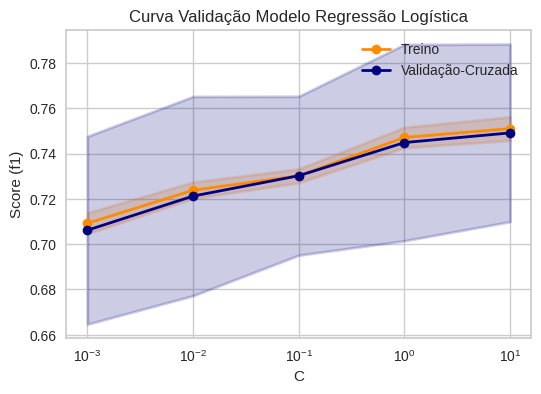

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.6434,0.6419,0.6667,0.6621,0.6644,0.2840,0.2840


Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8]
Scoring: f1


<Figure size 800x550 with 0 Axes>

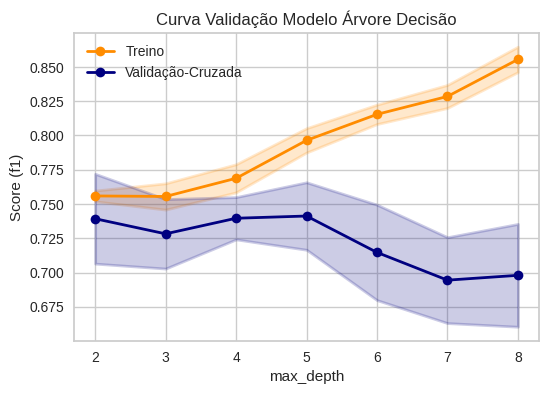

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8257,0.8725,0.7895,0.8654,0.8257,0.6521,0.6549
1,0.6972,0.7746,0.6842,0.7222,0.7027,0.3948,0.3953
2,0.7339,0.8147,0.6552,0.8085,0.7238,0.4726,0.4823
3,0.7615,0.8289,0.8276,0.7500,0.7869,0.5175,0.5208
4,0.7890,0.8469,0.7069,0.8723,0.7810,0.5817,0.5937
5,0.6881,0.7634,0.6724,0.7222,0.6964,0.3765,0.3775
6,0.7156,0.8151,0.6897,0.7547,0.7207,0.4322,0.4340
7,0.7407,0.7864,0.7895,0.7377,0.7627,0.4777,0.4791
8,0.7130,0.7874,0.7368,0.7241,0.7304,0.4236,0.4236


Fitting 10 folds for each of 4 candidates, totalling 40 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7169,0.7820,0.6597,0.7724,0.7116,0.4370,0.4422


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'model_vinho' already exists. Creating a new version of this model...
Created version '9' of model 'model_vinho'.
/tmp/ipykernel_304269/2438147459.py:84: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.0/model-registry.html#migrating-from-stages
  model_version = client.get_latest_versions(registered_model_name)[-1].version


<Figure size 800x550 with 0 Axes>

In [87]:
import os
from sklearn.metrics import log_loss, f1_score

registered_model_name = 'model_vinho'
nexamples = 5
model_version = -1

with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treinamento'):
  
    exp = pc.setup(
        data=xtrain,
        target = 'target',
        test_data = xtest,
        normalize=True,
        log_experiment = False
    )
    list_models = exp.compare_models(['lr','dt'], n_select=2, sort='f1')

    # REGRESSAO
    # exp.plot_model(list_models[0], plot='vc', save = True)
    yhat_test = exp.predict_model(list_models[0])
    plot_parameter_validation_curve(xtrain.drop('target', axis=1), ytrain, 'C', {'C': [0.001, 0.01, 0.1, 1, 10]},
                                        list_models[0], 'Regressão Logística', 'f1', logx=True)
    plt.savefig('lr_validation_curve.png')
    mlflow.log_artifact('lr_validation_curve.png')
    # os.remove('lr_validation_curve.png')
    
    mlflow.log_metrics({
        'lr_log_loss': log_loss(yhat_test.target, yhat_test.prediction_label),
        'lr_f1': f1_score(yhat_test.target, yhat_test.prediction_label),
    })
    
    # ARVORE
    yhat_test = exp.predict_model(list_models[1])
    plot_parameter_validation_curve(xtrain.drop('target', axis=1), ytrain, 'max_depth', {'max_depth': [2, 3, 4, 5, 6, 7, 8]},
                                    list_models[1], 'Árvore Decisão', 'f1', logx=False)
    plt.savefig('dt_validation_curve.png')
    mlflow.log_artifact('dt_validation_curve.png')
    # os.remove('dt_validation_curve.png')

    mlflow.log_metrics({
        'dt_log_loss': log_loss(yhat_test.target, yhat_test.prediction_label),
        'dt_f1': f1_score(yhat_test.target, yhat_test.prediction_label),
    })
    
     # FINALIZACAO MELHOR MODELO
    tune_model = exp.tune_model(list_models[0],
                                optimize = 'f1',
                                search_library = 'scikit-learn',
                                search_algorithm = 'random',
                                n_iter = 4)
    yhat_test = exp.predict_model(tune_model, raw_score=True)  
    mlflow.log_metrics({
        'final_model_log_loss': log_loss(yhat_test.target, yhat_test.prediction_label),
        'final_model_f1': f1_score(yhat_test.target, yhat_test.prediction_label),
    })
    yhat_test.to_parquet('../data/processed/prediction_test.parquet')
    mlflow.log_artifact('../data/processed/prediction_test.parquet')
    
    final_model = exp.finalize_model(tune_model)
    
    # EXPORTACAO PARA LOG E REGISTRO DO MODELO
    exp.save_model(final_model, f'./{registered_model_name}') 
    # Carrega novamente o pipeline + bestmodel
    model_pipe = exp.load_model(f'./{registered_model_name}')
    # Assinatura do Modelo Inferida pelo MLFlow
    model_features = list(xtrain.drop('target', axis=1).columns)
    inf_signature = infer_signature(xtrain[model_features], 
                                    model_pipe.predict_proba(xtrain.drop('target', axis=1)))
    # Exemplo de entrada para o MLmodel
    input_example = {x: xtrain[x].values[:nexamples] for x in model_features}
    # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="sklearn-model",
        registered_model_name=registered_model_name,
        signature = inf_signature,
        input_example = input_example,
        pyfunc_predict_fn='predict_proba'
    )
    # Criacao do cliente do servico MLFlow e atualizacao versao modelo
    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions(registered_model_name)[-1].version
    # Registrar o modelo como staging
    client.set_registered_model_alias(
        name    = registered_model_name, 
        alias   = "staging", 
        version = model_version
    )
    

